# Gradient estimation

For whatever reason, we want to know how functions inputs change their outputs. Sometimes we cannot use automatic differentiation to help us out. This might be because the function;

* has stochastic variables within it (can differentiate, but might not give sensible answers)
* has discrete variables in it discrete (and categorical) (ints, ...)
* is unknown to us.

Or maybe there are other complications, leading to _partial differentiability_;

* it's too big
* dont have access to make certain pertubations (may not be able to control some variables -- that is just back to stoachastic variables?!)
* structural/dynamic (closely related to discrete? this is more of a problem of propagation? can still estimate gradient, but cannot back prop them where we want. as no dependency exists?). various dtypes, trees, graphs, ... 

So, how can AD systems be made more general to handle these cases? Ideally we would have a automated differentiation system that can handle all combinations of these issues. (We might need a few more hyper parameters to control the tradeoff/accuracy of some approximations)

Thus allowing us to handle something like this:

```python
# want to train the web application's interface to be
# - soo intuitive that no questions need to be asked,
# - or soo facinating that many questions are asked,
# or train the knowledge graph to answer corretly
# or ...

web_app.run()  # the site we are optimising (many discrete variables)
natural_langual_query = web_app.watch_for_queries()  # human interaction (unknown fn)
query = nlp.parse(natural_langual_query)  # neural parser (cts and deep)
answer = knowledge_graph.answer(query)  # a relational database (a BIG graph)
reply = nlp.explain(answer)  # neural translation (cts and deep)
feedback = web_app.send(reply)  # human feedback (unknown fn)
web_app.train(feedback)
```

and all the AD is just automated in the background. So what we want is: functions that take arbitrary;

- stochastic fns and return a low variance, zero bias, estimator. `f: stochastic -> cts`
- discrete fns and return a softened/cts estimator. `g: discrete -> cts`
- black boxes and return a cts approximation (dynamically approximates it with something like boosting? it allocates capacity depending on accuracy). `h: unknown -> cts`
- ?

So we can just wrap the troublesome ops with these functions, and we are done. 
***

Cool. First, lets have a look at some of the existing problems and solutions.

# Contents

* [Stochastic](#stochastic)
* [(non)Smooth](#smooth)
* [Unknown](#unknown)
* [Recent work - stochastic, discrete, unknown](#recent)
* [Partial](#partial)

In [2]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import networkx as nx

# Sotchastic<a name="stochastic"></a>

Why does stochasticity mean we cant take the derivative?
Let $\bar x$ be some random variable, and let $\bar y = f(\bar x)$. So, we want $\frac{d\bar y}{d\bar x}$. (no this doesnt work... the problem occurs when f the function, $f$, is a stochastic function. $\bar y = f(\bar x, \epsilon)$


If we take $\frac{d\bar y}{d\bar x} \mid_x$ for $ x\sim X, y \sim Y$ and  

Dont know if $\Delta y$ is due to $\Delta \theta$ or noise produced by $\bar x$. _It is a credit assignment problem?_
If we have multiple RVs then what is the likelihood one of them produced $\Delta y$ versus the likelihood of our pertubation of $\theta$?

|      | Static noise           | Dynamic noise | Adversarial noise |
| ------------- |:-------------:| -----:| -----:|
| __Not-controllable__     | vanilla | ? | ? |
| __Partially-controllable__      | ?       |   ? | ? |


There is noise in floats, rounding errors, etc, but this isnt generally an issue. Why? The noise is small compared to the signal of interest?! $\frac{\text{signal}}{\text{noise}}$ is large.

### Controlled variables

Stochastic variables can be reframed through the lens of controllable and uncontrollable variables.


1.0279118533397273


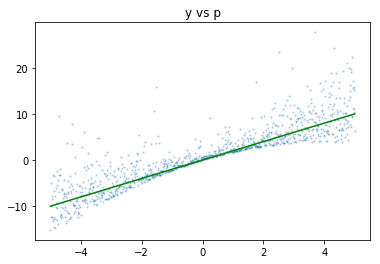

In [3]:
N = 1000
gaussian = lambda mean, stddev, N: rnd.standard_normal(N)*stddev + mean

p = np.linspace(-5, 5, N)
def fn(p):
    x = gaussian(0, 1, len(p))
    return x**2 + 2*p + x*p  # multiplicaive noise really fs things up...
y = fn(p)

# dydp = np.mean(2*x+p)   # take derivative and then marginalise
# must marginalise out the noise
# marginalisation works here because x is unbiased around 0
# print(dydp)

#####
# alternatively
E_y = np.mean(y)  # marginalise then take derivative
dydp = p
print(E_y)

plt.scatter(p, y, alpha=0.25, s=1.5)
plt.plot(p, 2*p, c='g')
_ = plt.title('y vs p')

(-10, 40)

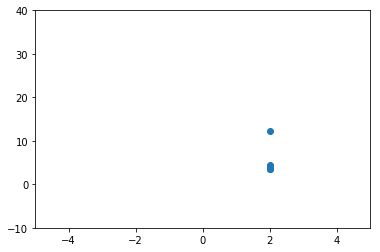

In [4]:
# ok, dydp seems clear, but what if we have fewer samples
n_samples = 5
p_val = 2
p = np.array([p_val]*n_samples)  # take n_samples at p=p_val
plt.scatter(p, fn(p))
plt.plot(p, 2*p, c='g', alpha=0.1)
plt.xlim(-5, 5)
plt.ylim(-10, 40)
# what is dydp?

# actually tbh, you still get a pretty decent estimate with
# few samples. what if we turn the variance up?

In [5]:
# what if the noise is biased!?

## Variance reduction
What is necessary to estimate a graident?
__Why do we care about variance reduction? If the estimate is accurate, what does it matter?__


A motivating example??? Show that optimisation with high variance is slower!?

In [6]:
def estimate(x):
    # cumlative mean
    return [np.mean(x[:i]) for i in range(1,N)]  # could be done recursively.

m_1 = estimate(gaussian(0, 1, N))
m_3 = estimate(gaussian(0, 4, N))
m_5 = estimate(gaussian(0, 8, N))

Text(0,0.5,'Estimated mean')

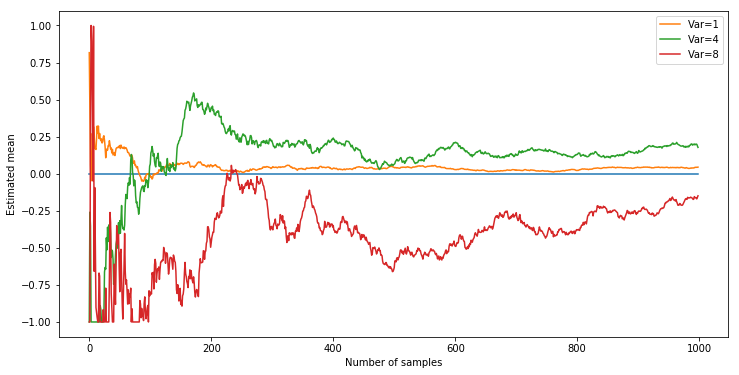

In [7]:
plt.figure(figsize=(12,6))
plt.plot(np.zeros(len(m_1)))
plt.plot(np.clip(m_1, -1, 1), label='Var=1')
plt.plot(np.clip(m_3, -1, 1), label='Var=4')
plt.plot(np.clip(m_5, -1, 1), label='Var=8')
plt.legend()
plt.xlabel('Number of samples')
plt.ylabel('Estimated mean')

Ok, so the mean tends to wander around more if there is more variance. So there must be a bound on the accuracy of the mean, given the variance!? 

$$
\epsilon = \mathbb E[x] - \frac{1}{N}\sum_{i=0}^N x \\
\epsilon = \mathcal O(\sigma)
$$

Still doesnt tell me why high variance matters... It matterns in the context of optimisation because !??!??

Need some unbiased estimator? But now the framework wont be functional anymore? As we need states to remember things, so we can calculate a mean field? Or we just do a large amount of expensive MC simulations?

## Control variates


* https://en.wikipedia.org/wiki/Control_variates
* Control Variates By Christiane Lemieux

> In order to reduce the variance $\sigma^2/n$, two approaches are possible. One is to replace the function $\hat h$ by an alternative function $\hat h$ such that $E( h(X))= μ$ but with $Var( h(X))
< σ^2$. This is the idea behind variance reduction techniques. The second approach consists of replacing the iid sampling scheme at the basis of Monte Carlo simulation by quasi-random sampling (see Random Number Generation and Quasi-Monte Carlo), thereby changing the $1/n$ convergence rate of the variance by possibly something as fast as $\mathcal O((log n)^d/n^3 )$, where d is the dimension of the problem. The method of control variates that we are
about to describe falls in the first category of approaches.

?

> First, we must find a random variable W such that μ w = E(W ) can be computed analytically and also such that Y and W are dependent.

?

> To see why this is useful, consider the case where
Y and W are positively correlated. Then if the naive estimator μ ̂ w,n is lower than its expected value of μ w ,
it suggests that probably μ ̂ n is also lower than the unknown μ, and therefore, a positive correction should
be added to it to reduce its error.

?

> As the goal of this technique is to get an estimator with smaller
variance than the naive Monte Carlo estimator, it makes sense to try to choose β so as to minimize the
variance of μ ̂ cv,n .

__Q__; Is tha really true? Sure we dont want to pick b to minimise the variance of the target fn?



__Q__; What about memory limited settings. When you cannot keep thousands of past 

In [8]:
n_samples = 2000

def F(x):
    return 1/(1+x)

samples = rnd.random(n_samples)
f = F(samples)

print(np.mean(f), np.var(f))

0.6932820982008469 0.01954957492575199


In [9]:
mean_g = 3/2  

def G(x):  
    # why this fn!?  
    # can different fns give better results?
    # why sorts of fns give better results? and why?
    # what if g is biased? biased to what alex... 
    # the whole point was that we chose a G that wasnt...
    return x + 1

g = G(samples)

c = -np.var(f)/np.cov(f,g)[0,1]  # want to derive this myself
# print(c)

output = f + c*(g - mean_g)  
# does this introduce any bias?
# seems like it should, why doesnt it?
# could try prove it? E[f] = E[f + c(g-mu_g)]

print('Mean: {}'.format(np.mean(output)), 
      '\nVariance: {}'.format(np.var(output)), 
      '\n{:.3f} times variance reduction'.format(np.var(f)/np.var(output))
     )

Mean: 0.6931665994360008 
Variance: 0.0006482637547647179 
30.157 times variance reduction


In [10]:
# ok, lets see f I am starting to understand.
# so if the control fn is more similar to
# the target fn then we should get more variance reduction?

mean_h = 0.4054  # found using samples
def H(x):  
    return  1/(x + 2)
h = H(samples)

c = -np.var(f)/np.cov(f,h)[0,1] 
output = f + c*(h - mean_h)  

print('Mean: {}'.format(np.mean(output)), 
      '\nVariance: {}'.format(np.var(output)), 
      '\n{:.3f} times variance reduction'.format(np.var(f)/np.var(output))
     )

Mean: 0.6929545420506888 
Variance: 0.00011064679579025057 
176.685 times variance reduction


Multiple control varaties. 

In the example above, we are kinda saying, assume F is similar to G. If our sample is from G is a distance from its mean then the sample is also a similar distance from F's mean.
When F isnt like G, this will be wrong, but not a big deal as that is what we used their correlation for. 

_What if we made $c$ a fn of the position of the sample? c(x)? Rather than a single linear approximation of the similarity between F and G we could tune it locally. 

Generalising this to many controls. Constraining F to be within G_i. If sample is greater than G_1, and G_2 but less than G_3 then assume the sample was slightly too high and correct it. (but what if we had extra/partial info that G_3 was very similar to F? -- this is what c is trying to correct for?!)

https://gabrielhuang.gitbooks.io/machine-learning/reparametrization-trick.html


## The reparameterisation trick

In some cases (which ones!??), a random variable $x \sim p_{\theta}(X)$ can be rewritten as a deterministic function of the parameters $\theta$ and another random variable $z$.

$$
\begin{align}
x \sim p_{\theta}(X) &\implies x = f(\theta, z) \tag{reparameterise} \\
x &\sim \mathcal N(\mu, \sigma) \tag{normal distribution} \\
x &= f(\mu, \sigma, z) \\
x &= \mu + \sigma^2 \cdot z \\
\end{align}
$$

So which distribution should we pick z from? What if we tried to learn that? Rather than jsut setting it to be gaussian/uniform? Surely setting the distribution would make the reparameterisation biased!? <- need to explore.

__TODO__ what about the variance in the reparameterised gradient!?

## Score functions

$$
x \sim p(x|\theta) \\
\nabla_{\theta} \mathbb E_x[f(x)] = \mathbb E_x [f(x)\nabla_{\theta} \log p(x | \theta)]
$$

How is this anything special? It is just chain rule?!

Where does p(x|\theta) come from? How is it calculated/estimated?

$$

$$

http://blog.shakirm.com/2015/11/machine-learning-trick-of-the-day-5-log-derivative-trick/

#### Reinforce

> This estimator is unbiased, but in general has high variance. Intuitively, this estimator is limited by the fact that it doesn’t use any information about how $f$
depends on $b$, only on the final outcome $f(b)$.





> If instead x is a deterministic function of θ and another random variable z, the operators∇θandEz commute, yielding the
pathwise  derivative  estimator or reparameterisation trick.
??

## Dice

* Why do we care about second order gradients?
* How did the old approaches fail?
* 

$\dicei$

Generalising AD to stochastic graphs. 

Why would we ever want to construct graphs with random variables in them? (not in them, but ?)
* Meta learning? Loss is a random variable (of the data)?
* RL?
* 

Approaches

* Surrogate objective and AD (although objective is the wrong way to view it as it is independent of loss functions)
* 

### Gumbel-max trick

Why does anyone care about the Gumbel max trick!?

$$
\begin{align}
\mathcal G &= -log(-log(\mathcal U)) \\
a_k &= P(x=k) \\
x \sim P(x)&\equiv \mathop{argmax}_k\log(a + g)  \;\;\;\; g \sim G \\
\end{align}
$$


Text(0.5,1,'The Gumbel distribution')

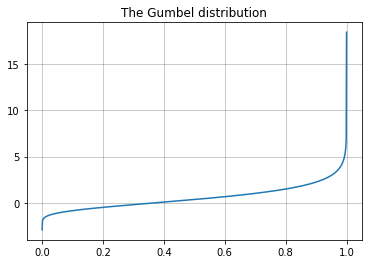

In [11]:
def gumbel_dist(u):
    return -np.log(-np.log(u))

U = np.linspace(1e-8, 1-1e-8, 1000)
G = gumbel_dist(U)
plt.plot(U, G)
plt.grid(b=True, which='major', color='k', alpha=0.25)
plt.title('The Gumbel distribution')

Need to add noise, else we just end up sampling the max everytime.

But why Gumbel distributed noise!?

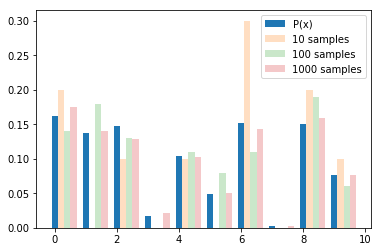

In [12]:
## want to explore an example. 
# just for sanity. 
# still skeptical and unsure about why it works

n = 10
P = rnd.random(n)
P /= np.sum(P)

def sample_gumbel_max_trick(a):
    """
    
    """
    u = gumbel_dist(rnd.random(len(a)))
    return np.argmax(np.log(a) + u)

def expected_gumbel(a, n_samples):
    samples = [sample_gumbel_max_trick(a) for i in range(n_samples)]
    h, _ = np.histogram(samples, bins=len(a))
    return h/np.sum(h)

width = 0.2
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(n), P, width, label='P(x)')
plt.bar(np.arange(n)+width, expected_gumbel(P, 10), width, alpha=0.25, label='10 samples')
plt.bar(np.arange(n)+2*width, expected_gumbel(P, 100), width, alpha=0.25, label='100 samples')
plt.bar(np.arange(n)+3*width, expected_gumbel(P, 1000), width, alpha=0.25, label='1000 samples')
plt.legend()

# (non)Smooth<a name="smooth"></a>

What we really care about; Locality/smothness and order? 

|      | Smooth           | Piecewise-smooth | Not smooth  |
| ------------- |:-------------:| -----:| -----:|
| __Ordered__     | cts | shattered |discrete |
| __Partially-Ordered__      | ?       |   ? | ? |
| __Not Ordered__      | reals without order!?       |   ? | categorical |

I mean smooth == local!?


## Piecewise-smooth


https://arxiv.org/abs/1702.08591

In [65]:
import autograd.numpy as np
from autograd import grad
from autograd import elementwise_grad as egrad

Text(0.5,0,'x')

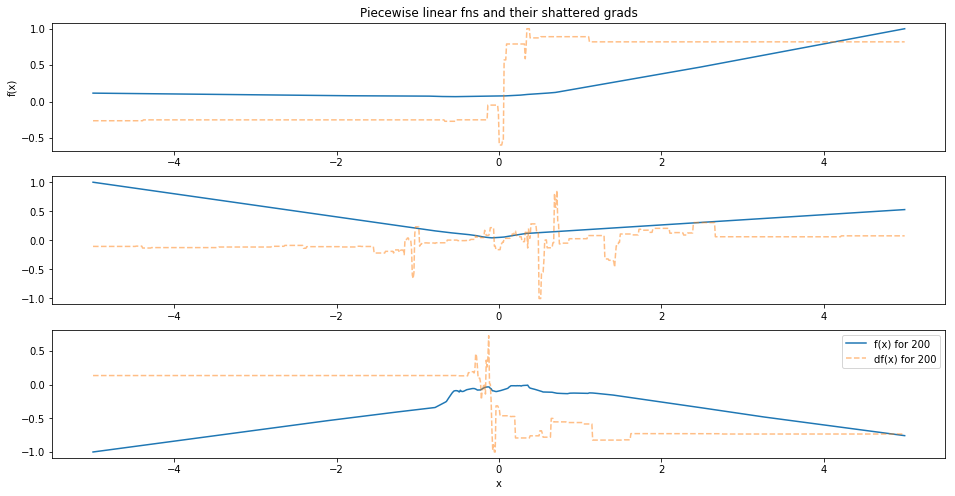

In [170]:
def relu(x):
    return np.maximum(x, 0)

def piecewise(x, n, fn):
    """
    Doesnt work if you only use scalars!?
    Needed to expand into a high dim.
    """
    x = np.expand_dims(x, 0)
    d = 10
    W = rnd.standard_normal((d, 1))
    x = np.dot(W, x)
    for i in range(n):
        a = rnd.standard_normal((d, d))
        b = rnd.standard_normal((d, 1))
        x = fn(np.dot(a, x) + b)
        
    W = rnd.standard_normal((1, d))
    x = np.dot(W, x)
    return np.squeeze(x)

def get_grad(n, fn):
    return egrad(lambda x: piecewise(x, n, fn))

x = np.linspace(-5, 5, 1000)

def plot(n):
    y = piecewise(x, n, relu)
    plt.plot(x, y/np.max(np.abs(y)), label='f(x) for {}'.format(n))
    d = get_grad(n, relu)(x)
    plt.plot(x, d/np.max(np.abs(d)), alpha=0.5, linestyle='--', label='df(x) for {}'.format(n))

plt.figure(figsize=(16, 8))

plt.subplot(3,1,1)
plot(2)
plt.ylabel('f(x)')
plt.title('Piecewise linear fns and their shattered grads')
plt.subplot(3,1,2)
plot(20)
plt.subplot(3,1,3)
plot(200)
plt.legend()
plt.xlabel('x')


# plots seem to be more shattered in the middle, is this because of the type of noise!?

Text(0.5,0,'x')

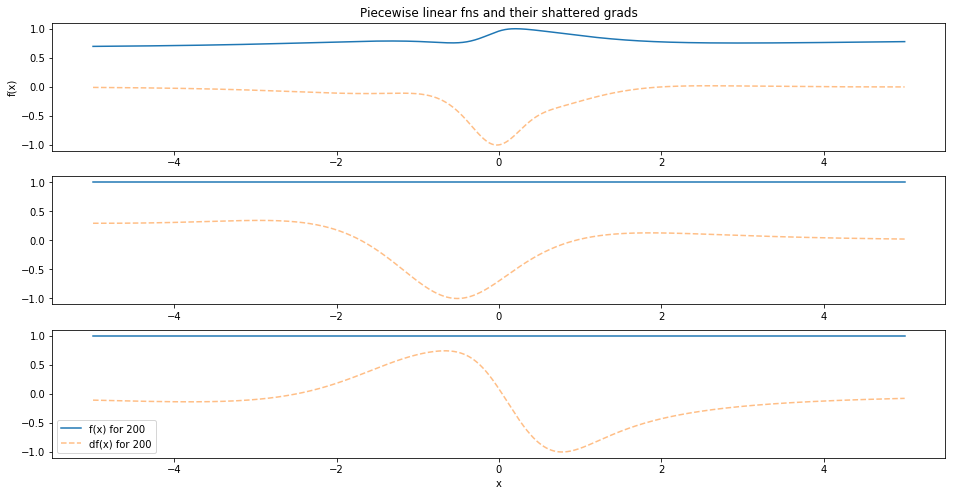

In [175]:
def sigmoid(z, t=1):
    return 1/(1+np.exp(-z/t))

def plot(n):
    y = piecewise(x, n, sigmoid)
    plt.plot(x, y/np.max(np.abs(y)), label='f(x) for {}'.format(n))
    d = get_grad(n, sigmoid)(x)
    plt.plot(x, d/np.max(np.abs(d)), alpha=0.5, linestyle='--', label='df(x) for {}'.format(n))

plt.figure(figsize=(16, 8))
plt.subplot(3,1,1)
plt.ylabel('f(x)')
plt.title('Piecewise linear fns and their shattered grads')
plot(2)
plt.subplot(3,1,2)
plot(20)
plt.subplot(3,1,3)
plot(200)
plt.legend()
plt.xlabel('x')

Huh, I expected this to be more shattered. This cts fn doesnt do so badly. But what if I turn up the temperature/sharpness for the sigmoid?

Yep, that does it.

***


The problem is that for large n locality is lost.
For low n, locality can still remain as;
- you are operating within a cts domain
- partitioned the space into linear regions 

__TODO__ (would like to make some of those partition plots!?)
What about tree search over the partitions!? They are each _weakly_ constrained by their neighbors. 

### Local statistics

Mean, variance, line of best fit, SVD!?
what about the variance!? that could tell us how trust worthy the estimate is!?

Solution? Despite all the craziness in the gradient, just sample a bunch of times and average!?

Text(0.5,0,'x')

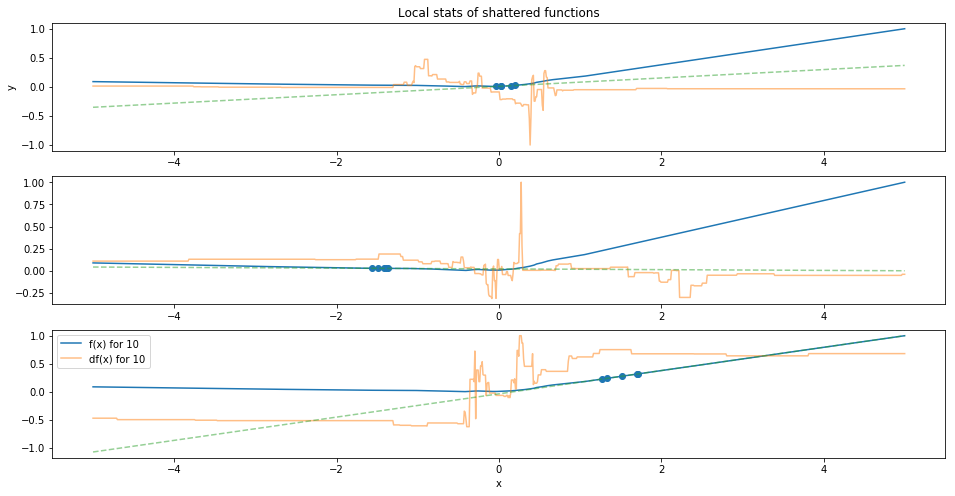

In [183]:
plt.figure(figsize=(16, 8))
y = piecewise(x, n, relu)

def plotter(x, y):
    plt.plot(x, y/np.max(np.abs(y)), label='f(x) for {}'.format(n))
    d = get_grad(n, relu)(x)
    plt.plot(x, d/np.max(np.abs(d)), alpha=0.5,label='df(x) for {}'.format(n))

def sample_avg_fit(loc, n_samples, width=25):
    r = int(loc*len(x))
    idx = rnd.randint(r-width, r+width, n_samples)
    best_fit = np.poly1d(np.polyfit(x[idx], y[idx]/np.max(np.abs(y)), 1))(x)
    return idx, best_fit

plt.subplot(3,1,1)
plt.ylabel('y')
plt.title('Local stats of shattered functions')

plotter(x, y)
idx, best_fit = sample_avg_fit(0.5, 5)
plt.scatter(x[idx], y[idx]/np.max(np.abs(y)))
plt.plot(x, best_fit, alpha=0.5, linestyle='--')

plt.subplot(3,1,2)
plotter(x, y)
idx, best_fit = sample_avg_fit(0.35, 5)
plt.scatter(x[idx], y[idx]/np.max(np.abs(y)))
plt.plot(x, best_fit, alpha=0.5, linestyle='--')

plt.subplot(3,1,3)
plotter(x, y)
idx, best_fit = sample_avg_fit(0.65, 5)
plt.scatter(x[idx], y[idx]/np.max(np.abs(y)))
plt.plot(x, best_fit, alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel('x')

## Softened

What do we mean by soft?

* Cts relaxations: e.g. sigmoids as a cts step fn, gumbel-softmax as a cts argmax.
* Look up -- skip gradients and regularise.
* Soft attention: Weighted sum rather than indexing
* ?

## Cts relaxations

<!-- are these general enough to cover things like mcts, sat,  -->

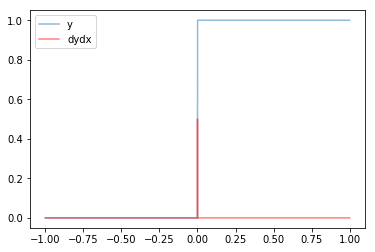

In [53]:
N = 10000
x = np.linspace(-1, 1, N)
y = (x > 0).astype(np.float32)
plt.plot(x, y, alpha=0.5, label='y')

# use finite differences to approximate as 
# the gradident of greater than isnt defined.
dydx = (y[1:] - y[:-1])/(2/N)
plt.plot(x[1:], dydx/N, c='r', alpha=0.5, label='dydx')
plt.legend()
# scale the grad so we can make sense of it

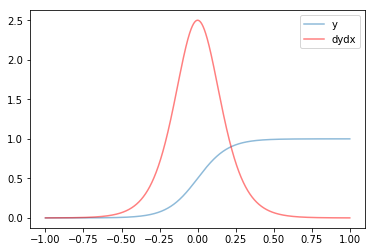

In [55]:
N = 10000
x = np.linspace(-1, 1, N)

def sigmoid(z, t=1):
    return 1/(1+np.exp(-z/t))
y = sigmoid(x, 0.1)
plt.plot(x, y, alpha=0.5, label='y')

# use finite differences to approximate as 
# the gradident of greater than isnt defined.
dydx = (y[1:] - y[:-1])/(2/N)
plt.plot(x[1:], dydx, c='r', alpha=0.5, label='dydx')
plt.legend()
# scale the grad so we can make sense of it

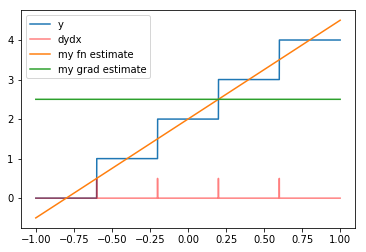

In [56]:
# what about many steps?
x = np.linspace(-1, 1, N)

def stepper(x, n):
    v = np.arange(n)
    m = len(x)//n
    return np.hstack([[v[i]]*m for i in range(n)])

n = 5
y = stepper(x, n)
plt.plot(x, y, label='y')

dydx = (y[1:] - y[:-1])/(2/N)
plt.plot(x[1:], dydx/N, c='r', alpha=0.5, label='dydx')
plt.plot(x, x*(n/2)+ n/2 - 0.5, label='my fn estimate')
plt.plot(x, np.ones_like(x)*(n/2), label='my grad estimate')
plt.legend()

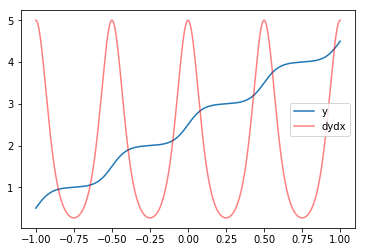

In [57]:
def soft_step(x, c, w):
    return 1/(1+np.exp(-w*(x+c)))

def soft_stepper(x, n):
    y = np.zeros_like(x)
    C = np.linspace(-1, 1, n)
    for i in range(n):
        y += soft_step(x, -C[i], 20)
    return y

y = soft_stepper(x, 5)
plt.plot(x, y, label='y')

dydx = (y[1:] - y[:-1])/(2/N)
plt.plot(x[1:], dydx, c='r', alpha=0.5, label='dydx')
plt.legend()

# not sure how helpful that is...
# hmm. all grad values are greater than zero,
# so if we were trying to do grad ascent then
# they should lead us in the right direction.

# fn is more accurate, 
# but the gradient seems less helpful

### Softmax

Well that is just an extension of the sigmoids from before

What about the tradeoff between accurate representation and differentiability.
__TODO__ Want to quantify how inaccurate the gradients are!??!

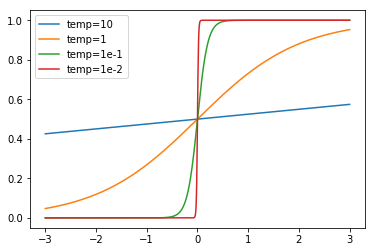

In [65]:
def softmax(z, t):
    return np.exp(z/t)/np.sum(np.exp(z/t))

x = np.linspace(-3, 3, 1000)
# just use sigmoid here to show visualisation.
# but the same applies to softmax
plt.plot(x, sigmoid(x, 10), label='temp=10')
plt.plot(x, sigmoid(x, 1), label='temp=1')
plt.plot(x, sigmoid(x, 1e-1), label='temp=1e-1')
plt.plot(x, sigmoid(x, 1e-2), label='temp=1e-2')
plt.legend()

### Problems with 'soft' relaxations

Most use of 'soft' version of the function. To achieve this the gradients end up vanishing (sigmoids, ...)



## Weighted attention



In [2]:
# instead of making a discrete choice, we take a weighted sum. 
# The weights are optimised to be sparse.


## Partially-ordered

I meant in two ways
- Like a poset!
- Orderable


## Locality

You can have locality in graphs, as long as you have some __metric__ to order the nodes and construct the adjacency matrix. 
So the metric is the key!?

So when we use the reals our metric is ???

In [205]:
# connectedness using neighbors?!
# label propagation of loss?
# have some underlying topology of how fns are related.
# can query loss at some nodes and propagate loss the graph?!

# what if we did this for NNs?
# calculate their distance from each other in parameter space?
# MUST be better alternatives for measuing similarity/constructing the graph
# would be expensive to keep the actual parameter, but could easily store the graph

T = rnd.standard_normal((10,1))

def loss_fn(x):  # loss is distance from T
    return np.sum(np.power(x - T, 2))

n = 20
NNs = [rnd.standard_normal((10,1)) for _ in range(n)]
distances = np.array([[np.linalg.norm(a-b) for a in NNs] for b in NNs])
distances = distances / np.linalg.norm(distances, axis=0)  # is this the right axis?
losses = [loss_fn(nn) for nn in NNs[:n//2]] # only test the first half
losses = np.array(losses + [0]*(n//2))  # we dont know the loss of the other half

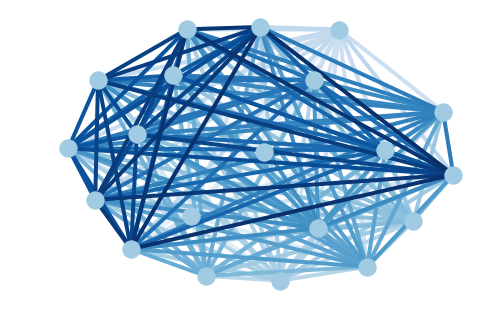

In [206]:
# m = rnd.choice([0,1], (8,8,), p=[0.7, 0.3])
g = nx.from_numpy_matrix(distances)
g = nx.convert_node_labels_to_integers(g)
colors = range(len(g.edges))
nx.draw(g,pos=nx.spring_layout(G), 
        node_color='#A0CBE2',
        edge_color=colors,
        width=4,
        edge_cmap=plt.cm.Blues,
        with_labels=False)
plt.show() # display

In [207]:
losses

array([20.2378646 , 21.95555553,  5.49127983, 13.96022894, 23.21754545,
       11.92296158, 10.38851321,  7.66327525, 17.79251064, 15.1077228 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [208]:
np.inner(distances, losses)

array([29.621753  , 28.34841681, 32.16745621, 26.40204525, 27.44440327,
       28.02007125, 35.28426973, 28.58625361, 29.7459798 , 26.60329524,
       37.53892136, 34.57792728, 37.9942555 , 30.55105338, 33.86065416,
       33.57551757, 32.81755978, 35.64412152, 37.3795428 , 28.88069098])

In [209]:
[loss_fn(nn) for nn in NNs[n//2:]] # only test the first half

[15.664269938039999,
 16.604738263119025,
 17.569332354305367,
 8.057424451951501,
 13.049781370131504,
 18.407356390007173,
 15.68041532023816,
 22.842833849934504,
 17.322598039588833,
 11.243450623823959]

### Categorical

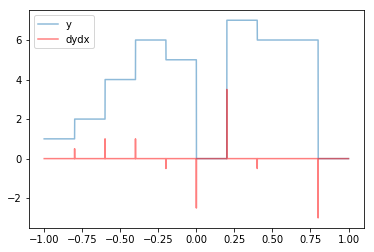

In [109]:
# what about categorical variables?
def categorical(x, n):
    y = np.zeros_like(x)
    m = len(x)//n
    for i in range(n):
        # what if n is correlated with x
        y[m*i:m*(i+1)] = rnd.randint(0, n)
    return y

y = categorical(x, 10)
plt.plot(x, y, alpha=0.5, label='y')
dydx = (y[1:] - y[:-1])/(2/N)
plt.plot(x[1:], dydx/N, c='r', alpha=0.5, label='dydx')
plt.legend()

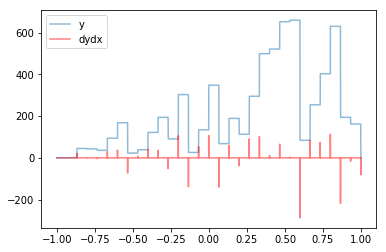

In [110]:
# what about weak ordering of dimensions?
# DEFINE weak ordering!?
# somewhere in between discrete and categorical variables
# for example, below

def categorical(x, n):
    y = np.zeros_like(x)
    m = len(x)//n
    for i in range(n):
        # what if n is correlated with x
        y[m*i:m*(i+1)] = rnd.randint(0, n*i+1)
    return y

y = categorical(x, 30)
plt.plot(x, y, alpha=0.5, label='y')
dydx = (y[1:] - y[:-1])/(2/N)
plt.plot(x[1:], dydx/N, c='r', alpha=0.5, label='dydx')
plt.legend()

# what if indices have noise? cant trust the ordering!!!
# that is the main reason stochasticity is hard!?@?!#?
# what if we were allowed to perturb the indices and do a local sort/perturb?
# assuming the noise is ?? then this could work?

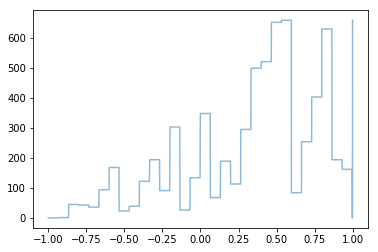

In [117]:
def sort_1_step(x, y):
    # if your 2-neighbor is more similar to you
    # than your 1-neighbor then swap
    # we are assuming x is arbitrary so we can move it around.
    a = x.copy()
    b = y.copy()
    for i in range(len(x)-1):
        if b[i] > b[i+1]: 
#             a[i:i] = list(reversed(a[i:i+2]))
            b[i:i+2] = list(reversed(b[i:i+2]))
    return a, b
            
x, y = sort_1_step(x, y)
plt.plot(x, y, alpha=0.5, label='y')
# dydx = (y[1:] - y[:-1])/(2/N)
# plt.plot(x[1:], dydx/N, c='r', alpha=0.5, label='dydx')
# plt.legend()

# Unknown<a name="unknown"></a>

Two approaches (that I know of);

> model-free: _Use the unknown black box to estimate gradients using finite differences or ...?_

and

> model-based: _Construct a differentiable approximation of the black box._

* What information do we get from the black box? and what do we already know about it?
* do we want higher order gradients?

## Model-free

Can be expensive. Also, if noise is present in the blackbox, this can complicate things.
Alternate perspective, we are just fitting a cheap (linear) model.


***

Is there a more general formuation of differences that unifies; finite, temporal, counterfactual, ...?
What are these used for? Why do we care?


Quick review;

A derivative is defined as the limit of a finite difference.
$$
f'(x)=\lim _{h\to 0}{\frac {f(x+h)-f(x)}{h}}
$$

> The difference quotient is a measure of the average rate of change of the function over an interval

(that doesnt seem true, it just looks at the two ends, not how the fn changes inbetween? oh, maybe this is right?)

A counterfactual

$$
f(x) - f(x')
$$


A couple of notes. 

* Even if the difference is not scaled properly (with h, or the run) the direction will still be correct.
* Estimating higher order derivatives with differences (does it get harder?).
* What if the function is noisy? A difference no longer gives a reliable estimate...
* Maybe I should look at target difference prop again?

## Higher order differences

https://en.wikipedia.org/wiki/Recurrence_relation#Relationship_to_difference_equations_narrowly_defined
More generally: the kth difference of the sequence an written as $$Δ k ( a_n ) {\displaystyle \Delta ^{k}(a_{n})} \Delta ^{k}(a_{n}) $$is defined recursively as

$$\Delta^k (a_n) = \Delta^{k−1}(a_{n+1}) − \Delta^{k−1}(a_n) = \sum^k_{t=0}  {k \choose t} (-1)^t a_{n+k-t}$$

What about for multidimensional variables!?

## Blackbox backpropagation with jacobian sensing

> Efficient coloring of G weak int for reducing the dimensionality of the problem, where each variable in the compressed problem corresponds to a subset of variables in the original problem.


#### Goal, recover the jacobian efficiently.
* If you happen to know the computation graph then just do AD.
* If you can make an accurate guess about the graph, then ?? (also how would the guess be improved?)
* If you have partial information about the graph structure (sparsity structure of adjacency, then this is the solution!?)
    * What if the adjacency had probabilities of being connected, rather than abs values, 0, 1.
    * what if it has blocks?
    * symmetry?!? positive definiteness? rank? ...
* If you have partial information about the contents of the graph?
    * Edge types?
    * ?
* 

Worst case. n function calls. Which for nns, might be ~1000000...

***

If we have a nested fn, such as $y = f_{\theta}(g_{\phi}(x))$, then what does this tell us about the structure of the jacobian (and/or hessian?)? Let $\psi = [\theta; \phi]$. 
$$\frac{\partial y}{\partial \psi} =
\begin{bmatrix}
\frac{\partial y}{\partial \theta} \\
\frac{\partial y}{\partial z}\frac{\partial z}{\partial \phi} \\
\end{bmatrix}
$$

***

#### Goal, recover the graph efficiently.

In the non linear case, how do you represent the jacobian? Just use some arbitrary fn approximator? Can we find an approximator suited for this problem? What is unique to the problem?



* How can this be generalised to noisy settings?
* How can the sparsity structure be estimated? (what about noise...)
* Ok, so model-base vs model-free. In the model free version we must estimate the gradients every time. Finite difference ... So how well does this scale? 
* What about non square matrices!?

In [2]:
import autograd.numpy as np
from autograd import grad, jacobian

In [57]:
def greedy_coloring(graph):
    """
    Args:
        graph (nx.graph): The graph to be colored
        
    Returns:
        (dict): mapping from colors (the keys) to nodes (the values)
    """
    nodes = list(graph.nodes())
    stable_sets = {0: [nodes[0]]}
    
    # for each node, put it in a stable set
    for v in nodes[1:]:
        done = False
        counter = 0
        while not done:
            # if we cannot add the node to any existing
            # stable sets, make a new one
            if counter not in list(stable_sets.keys()):
                stable_sets[counter] = [v]
                done = True
                break
            
            # add the curret node, v, to a stable set that 
            # has none if its neighbors
            add = False
            for s in stable_sets[counter]:  # check each neighbor
                if (v, s) in graph.edges():
                    add = False
                    break
                else:
                    add = True
            if add:
                stable_sets[counter].append(v)
                break
                    
            counter += 1
    return stable_sets

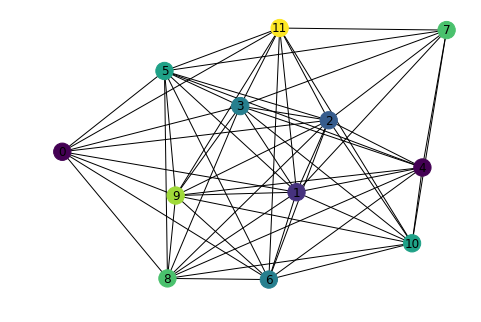

In [65]:
m = np.random.randint(0, 2, (12,12))
g = nx.from_numpy_array(m)
coloring = greedy_coloring(g)
node_colors = list(sorted([(i, k) for k,v in coloring.items() for i in v]))
node_colors = [j for i, j in node_colors]
nx.draw(g, node_color=node_colors, with_labels=True)

In [66]:
def rainbow(fn, m):
    # color the inputs
    g = nx.from_numpy_array(m)
    coloring = greedy_coloring(g)
    
    # peturb in the reduced dim space
    d_core = np.random.standard_normal(8)
    # ???
    ds = np.array([np.zeros(m.shape[0]) for k,v in coloring.items()])
    d = np.random.standard_normal((8,8))  # should be k by 
    r = fn(d)
    
    # slove lp problem
    x = np.linalg.solve(r, d)
    return x

In [67]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

out = rainbow(sigmoid, np.random.randint(0,2,(8,8)))
out.shape

(8, 8)

TODO. test the implementation.
Plot it's computational complexity.
?

## Estimating the interaction graph

Want to extend this work to estimating the interaction graph.
But, noise makes this nontrivial.

* How does a nonlinear functions interaction graph change over the space of its inputs (and parameters?). 
* Want to recover a graph from data. Can use correlations to find direct connections, then higher order moments to find other connections? 

In [76]:
# if we take a vanilla neural network. 
# its jacobian has low sparsity (wrt inputs, but what about params?)

def layer(shape):
    W = np.random.standard_normal(shape)
    return lambda x: sigmoid(np.dot(x, W))
    
def generate_rnd_fn(shape):
    
    def fn(x):
        l1 = layer((shape[0], 20))
        l2 = layer((20, shape[-1]))
        return l2(l1(x))
    
    return fn

In [77]:
batch_size = 100
n_inputs = 28
n_outputs = 10
fn = generate_rnd_fn((n_inputs, n_outputs))
x = np.random.random((batch_size, n_inputs))
y = fn(x)
dfn = jacobian(fn)
j = dfn(x)
# j = np.mean(j, axis=(0,2)) # aggregate

In [78]:
def expand(x, dims):
    for dim in dims:
        x = np.expand_dims(x, dim)
    return x

In [80]:
def intersection_graph(mat, tol):
    # sparsify the jacobian by rounding small values to zero
    intersection = np.greater(mat, tol)
    intersection += np.greater(-mat, tol)
    return intersection.astype(np.float32)

intersection_graphs = [intersection_graph(j[i, :, i, :], 1e-1) for i in range(batch_size)]

In [81]:
degrees = [np.max(np.sum(g, axis=0)) for g in intersection_graphs]
print(degrees)

[6.0, 5.0, 6.0, 5.0, 5.0, 4.0, 6.0, 6.0, 7.0, 6.0, 4.0, 6.0, 5.0, 6.0, 5.0, 5.0, 7.0, 4.0, 5.0, 6.0, 5.0, 5.0, 6.0, 6.0, 5.0, 5.0, 5.0, 7.0, 6.0, 5.0, 7.0, 2.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 4.0, 6.0, 6.0, 5.0, 7.0, 4.0, 7.0, 6.0, 6.0, 6.0, 5.0, 6.0, 5.0, 6.0, 6.0, 6.0, 7.0, 4.0, 7.0, 6.0, 4.0, 4.0, 5.0, 3.0, 5.0, 4.0, 5.0, 6.0, 7.0, 6.0, 6.0, 5.0, 4.0, 5.0, 6.0, 5.0, 6.0, 6.0, 5.0, 6.0, 5.0, 6.0, 6.0, 7.0, 6.0, 3.0, 6.0, 6.0, 5.0, 5.0, 5.0, 4.0, 6.0, 6.0, 7.0, 6.0, 6.0, 4.0, 6.0, 4.0, 6.0, 6.0]


In [82]:
d = np.array([[np.sum(np.abs(a - b)) 
               for b in intersection_graphs] 
              for a in intersection_graphs])

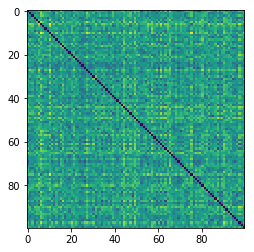

In [83]:
plt.imshow(d)

## ?

Wait a minute. If we have already compute a batch of activations, can we fit a linear model to these? How accurate is this to estimate the gradient?

(ps. why linear model. They are cheap. Only require 2 points per dimension!?) 

In [121]:
def batch_difference(y, x):
    # take a linear approximation over a batch
    dx = expand(x, [1]) - expand(x, [0])
    dy = expand(y, [1]) - expand(y, [0])
    # rise over run
    dydx = expand(dy.T, [-1])/(expand(dx, [0]) + 1e-8)
    return np.transpose(dydx, [1,0,2,3])


batch_size = 20
n_inputs = 784
n_outputs = 10
fn = generate_rnd_fn((n_inputs, n_outputs))
x = np.random.random((batch_size, n_inputs))
y = fn(x)
dfn = jacobian(fn)
j = dfn(x)
dydx = batch_difference(y, x)
np.sum(np.mean(np.power(dydx - j, 2), axis=(0,2)))

355958565.4562501

## Model-based

- What about approximate estimation? What if our approximation is inaccurate? Relation to synthetic gradients?
- [World models](https://worldmodels.github.io/)

how can this be done efficiently? which priors are best for the types of models we will want to learn? how can we make a language for accepting arbitrary priors? 

### Approximate with a neural network

?
- no guarantees for 'new' data
- what about when the neural network is first learning, the gradients will be nonsensible.
- 

### Synthetic grads

?

# Recent work<a name="recent"></a>

Putting the above tools together into an estimator for stochastic, discrete, and unknown functions.

## The gumbel-softmax trick

The reprarmeteriseation trick for stochastic dicrete variables.

$$
G=−log(−log(U)) \\
U \sim Unif[0,1] \\
P(X=k) = \alpha_k \\
X=\mathop{argmax}_k log(\alpha_k)+G_k\\
$$


https://cmaddis.github.io/

## Rebar

Our strategy will be to construct a control variate based on the difference between the REINFORCE gradient estimator for the relaxed model and the gradient estimator from the reparameterization trick.

how does this work with mini-batches!?

What is more similar to our function that another estimate of our fnction? Where can we get an accurate estimate of the mean of our fn?


$$
\begin{align*}
\mathbb E_{p(b)} [f(b, \theta)]& && \text{Want to maximise}\\
\frac{\partial f}{\partial \theta} \mathbb E_{p (b)} [f(b, \theta)]&= \sum \big[ \frac{\partial p(b)}{\partial \theta} f(b, \theta) +  p(b) \frac{\partial f(b, \theta)}{\partial \theta} \big] && \text{do GD on 1.}\\
x &=1   && x \text{ must be one}
\end{align*}
$$

https://github.com/tensorflow/models/tree/master/research/rebar

In [1]:
def rebar():
    pass

## RELAX (Bprop through the void)

https://github.com/wgrathwohl/BackpropThroughTheVoidRL

When $c_{\phi} = f$, then LAX becomes the reparameterization estimator for $f$.

How to find $c_{\phi}$? 

* $argmin_{\phi} (f(b) - c_{\phi}(b))^2$  (Relationship to actor-critic!? and qprop?!?)
* $argmin_{\phi} Var(\hat g)$

Seems very clear here? We are jointly learning a model of f(b)!
Are there pathogogical minima when trying to minimise variance? Seems dangerous?



***

Getting more info from stochastic gradients!
How can we measure the info in a set of feedback? Reliability/variance, first order vs 2nd order, ...?


***

* tbh, their experiments are abit dodgy? unclear if it works better than rebar.
* more accurate gradients means less noise... possibly less exploration..
* interesting problem. works ok for markov processes. but what about partial info settings. they are going to have biased estimators!?
* now we have a bunch of hyper param for $c_{\phi}$. What if it starts overfitting or diverges?
* one accurate estimators vs many less accurate ones!?
* i am a little confused as to what the contribution of this paper is... seems very incremental
* getting access to a_t created a longer dependency?
* relationship to Doubly Robust Estimation?

In [ ]:
def RELAX():
    pass

|      |  |            | Algol | Accuracy |
| ------------- |:-------------:| -----:| -----:|
| __Known__     | __Cts__ | __Not stochastic__ | vanilla | ? |
| __Unknown__   | __Cts__ | __Not stochastic__ | Approximate | ? |
| __Known__     | __Not Cts__ | __Not stochastic__ | ? | ? |
| __Unknown__   | __Not Cts__ | __Not stochastic__ | ? | ? |
| __Known__     | __Cts__ | __Stochastic__ | ? | ? |
| __Unknown__   | __Cts__ | __Stochastic__ | Approximate | ? |
| __Known__     | __Not Cts__ | __Stochastic__ | REBAR | ? |
| __Unknown__   | __Not Cts__ | __Stochastic__ | RELAX | ? |

__TODO__ Want to construct this from data!
- Evaluate the accuracies
- What about various methods; 
    - model-free vs model-based.
    - reparam vs control variate vs score ...

# Partial<a name="partial"></a>

Problems
* Too big (a few different types of to big...)
* Local pertubations

Solutions
* Unroll
* Dynamic computation graphs
* Truncated backprop
* ?

# Resources

* http://timvieira.github.io/blog/
* https://casmls.github.io/general/2017/02/01/GumbelSoftmax.html
